# Disparity Map test
In this file I tested two implementation for computing the disparity map, comparing the result with the openCV method.

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import sys

## Dataset

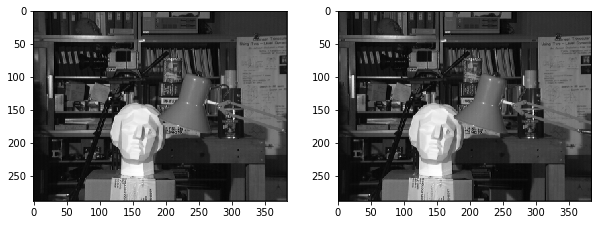

In [2]:
imgL = cv2.imread('tsukuba_l.png',0)
imgR = cv2.imread('tsukuba_r.png',0)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(imgL, 'gray')
plt.subplot(1,2,2)
plt.imshow(imgR, 'gray')
plt.show()

## Expected result (openCV method)

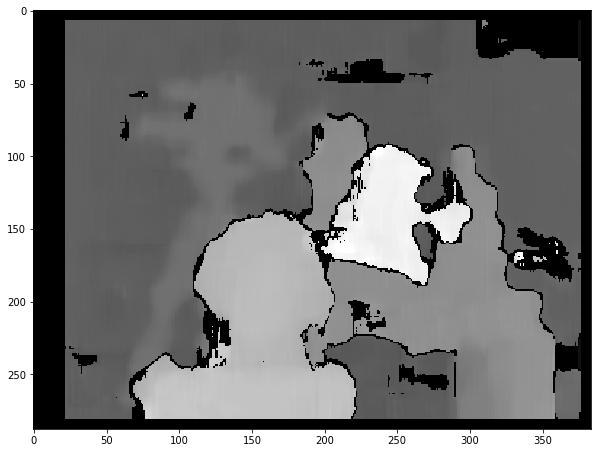

In [3]:
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
opencv_disparity = stereo.compute(imgL,imgR)

plt.figure(figsize=(10,20))
plt.imshow(opencv_disparity,'gray')
plt.show()

## First implementation

In [4]:
def SAD(window1, window2):
    return np.sum(np.abs(window1 - window2))

In [5]:
disparity_range = range(0, 16)

# Dissimilarity/Similarity measure
M_SAD = 0
M_SSD = 1
M_NCC = 2
M_ZNCC = 3

def computeDisparityMap(left_image, right_image, area_size, block_size, disparity_range=disparity_range):

    # Check parameters
    if (block_size%2 != 1 | 
        block_size==1 | 
        block_size > left_image.shape[0] |
        block_size > left_image.shape[1]):
        raise Exception("block_size must be odd, greater than 1, and be not larger than image width or height")
    
    if (area_size > left_image.shape[0] |
        area_size > left_image.shape[1]):
        raise Exception("area_size must not be larger than the image width or height")

    disparity_map = np.zeros((left_image.shape[0], left_image.shape[1]), dtype=int)
    left_image_f = np.float32(left_image)
    right_image_f = np.float32(right_image)
    
    n = block_size // 2      #block_size = 2n+1

    v_min = (left_image.shape[0]-area_size)//2
    v_max = (left_image.shape[0]+area_size)//2
    u_min = (left_image.shape[1]-area_size)//2
    u_max = (left_image.shape[1]+area_size)//2


    for v in range(v_min, v_max):
        for u in range(u_min, u_max):
            # variables to store the best value
            best_value = 0
            u_R = 0
            best_value = sys.maxsize

            # We will use the left image as the reference image
            template = left_image_f[v-n:v+n+1, u-n:u+n+1]

            for i in disparity_range:
                # compute the similarity or dissimilarity between two windows             
                # we will slide over the left
                window = right_image_f[v-n:v+n+1, u-n-i:u+n-i+1]
                
                sad = SAD(template, window)
                if sad < best_value:
                    best_value = sad
                    u_R = u-i

            disparity_map[v,u] = u-u_R   #left - right
            
    return disparity_map[v_min:v_max, u_min:u_max]

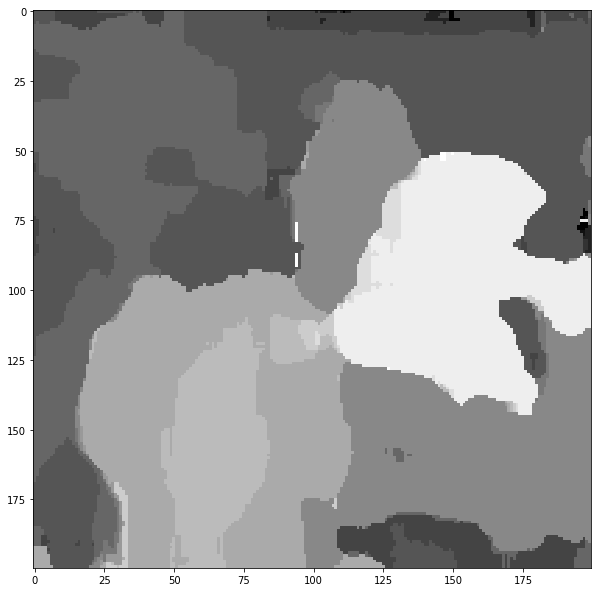

In [6]:
disparity_map = computeDisparityMap(imgL, imgR, area_size=200, block_size=15, disparity_range=range(0,16))

plt.figure(figsize=(10,20))
plt.imshow(disparity_map, "gray")
plt.show()

## Fast implementation
(based on https://sites.google.com/site/5kk73gpu2010/assignments/stereo-vision#TOC-Update-Disparity-Map)

In [7]:
disparity_range = range(0, 16)

def computeFastDisparityMap(left_image, right_image, area_size, block_size, disparity_range=disparity_range):

    # Check parameters
    if (block_size%2 != 1 | 
        block_size==1 | 
        block_size > left_image.shape[0] |
        block_size > left_image.shape[1]):
        raise Exception("block_size must be odd, greater than 1, and be not larger than image width or height")

    if (area_size > left_image.shape[0] |
        area_size > left_image.shape[1]):
        raise Exception("area_size must not be larger than the image width or height")
    
    kernel = np.ones([block_size, block_size])
    sad_maps = np.zeros([area_size, area_size, len(disparity_range)])
    left_image_f = np.float32(left_image)
    right_image_f = np.float32(right_image)
    
    # Translate the image and crop, in order to obtain a central area_size x area_size pixels area
    left_translation = np.float32([[1, 0, -(left_image.shape[1]-area_size)//2], 
                              [0, 1, -(left_image.shape[0]-area_size)//2]])
    
    left_ROI = cv2.warpAffine(left_image_f, left_translation, (area_size, area_size))

    for i in disparity_range:
        # The right image must be shifted each for loop
        right_translation = left_translation + ([[0,0,i],[0,0,0]])
        right_ROI = cv2.warpAffine(right_image_f, right_translation, (area_size, area_size))

        # Calculate absolute differences
        absolute_differences = np.abs(left_ROI - right_ROI)

        # Convolve with kernel and compute SAD at each point
        sad_map = cv2.filter2D(
            src = absolute_differences,
            ddepth = -1,
            kernel = kernel, 
            borderType=cv2.BORDER_ISOLATED)
        sad_maps[:, :, i-disparity_range[0]] = sad_map
    
    # The disparity values are the indices of the minimum sad values, plus the starting value
    # of the disparity range
    disparity_map = np.argmin(sad_maps, axis=-1)
    disparity_map += disparity_range[0]

    return disparity_map

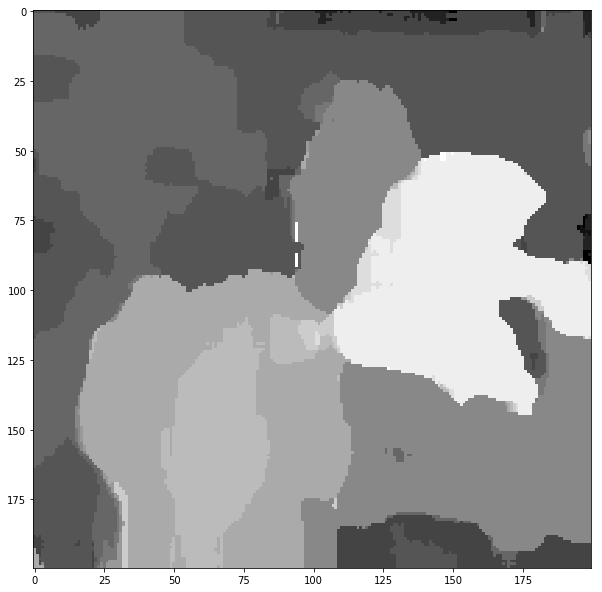

In [8]:
fast_disparity_map = computeFastDisparityMap(imgL, imgR, area_size=200, block_size=15, disparity_range=range(0,16))

plt.figure(figsize=(10,20))
plt.imshow(fast_disparity_map, "gray")
plt.show()